In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import os
import cv2
import numpy as np
DATA_PATH = '/home/dkube/work/dataset/'
annot = pd.read_csv(DATA_PATH + 'cellular-images-ocdkube/train.csv')
annot.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
name_label_dict = {
                    0:  'Nucleoplasm',
                    1:  'Nuclear membrane',
                    2:  'Nucleoli',   
                    3:  'Nucleoli fibrillar center',
                    4:  'Nuclear speckles',
                    5:  'Nuclear bodies',
                    6:  'Endoplasmic reticulum',   
                    7:  'Golgi apparatus',
                    8:  'Peroxisomes',
                    9:  'Endosomes',
                    10:  'Lysosomes',
                    11:  'Intermediate filaments',
                    12:  'Actin filaments',
                    13:  'Focal adhesion sites',   
                    14:  'Microtubules',
                    15:  'Microtubule ends',  
                    16:  'Cytokinetic bridge',   
                    17:  'Mitotic spindle',
                    18:  'Microtubule organizing center',  
                    19:  'Centrosome',
                    20:  'Lipid droplets',
                    21:  'Plasma membrane',   
                    22:  'Cell junctions', 
                    23:  'Mitochondria',
                    24:  'Aggresome',
                    25:  'Cytosol',
                    26:  'Cytoplasmic bodies',   
                    27:  'Rods & rings' }

In [5]:
def open_rgby(path,id):
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id + '_' + color + '.png'), flags) for color in colors]
    img = np.stack(img, axis=-1)
    img = cv2.resize(img, (512, 512))
    return img

In [6]:
def build_annot(image_file):
    
    img = cv2.imread(image_file)

    imCopy = img.copy()
    imgray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 40, 255, 0)
    contours, hierarchy =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    x_min = list()
    x_max = list()
    y_min = list()
    y_max = list()
    my_images = list()
    my_classes = list()
    for (i, c) in enumerate(cnts):    
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 30 and w < 100 and h > 30 and h < 100:
            if x-20>0:
                x_min.append(x-20)
            else:
                x_min.append(0)
            x_max.append(x + w + 20)
            if y-20>0:
                y_min.append(y-20)
            else:
                y_min.append(0)
            y_max.append(y + h + 20)
            my_images.append('Nucleoplasm_Cytosol_train/' + image_file)
            my_classes.append(str(np.where(image_file in annot[annot['Target']=='0'].Id.values + '.png', 
                                           'Nucleoplasm', 'Cytosol')))
    
    annot_df = pd.DataFrame({'Image': my_images,
                             'xmin': x_min, 'xmax': x_max, 'ymin': y_min, 'ymax': y_max,
                             'Class': my_classes})
    return annot_df

In [7]:
temp_path = '/home/dkube/work/workspace/'
if not os.path.exists(temp_path + 'Nucleoplasm_Cytosol_train'):
    os.makedirs(temp_path + 'Nucleoplasm_Cytosol_train')
j=0
ids = np.append(annot[annot['Target']=='0'].Id.values, annot[annot['Target']=='25'].Id.values)
for each_id in ids:
    temp_img = open_rgby(DATA_PATH + 'cellular-images-ocdkube/train/', each_id)
    cv2.imwrite(temp_path + 'Nucleoplasm_Cytosol_train/' + each_id + '.png', temp_img)
    j += 1
    if j%1000==0:
        print('Finished Merging ' + str(j) + ' images')

Finished Merging 1000 images
Finished Merging 2000 images
Finished Merging 3000 images


In [8]:
annot_df = pd.DataFrame()
j=0
merged_imgs = os.listdir(temp_path + 'Nucleoplasm_Cytosol_train/')
for each_img in merged_imgs:
    annot_df = pd.concat([annot_df, build_annot(temp_path + 'Nucleoplasm_Cytosol_train/' + each_img)], 
                         ignore_index=True)
    j = j + 1
    if j%1000==0:
        print('Finished Annotating ' + str(j) + ' images')

Finished Annotating 1000 images
Finished Annotating 2000 images
Finished Annotating 3000 images


In [9]:
annot_df.to_csv(temp_path + 'annot.csv', index=False, sep=',')

In [10]:
len(annot_df)

36550

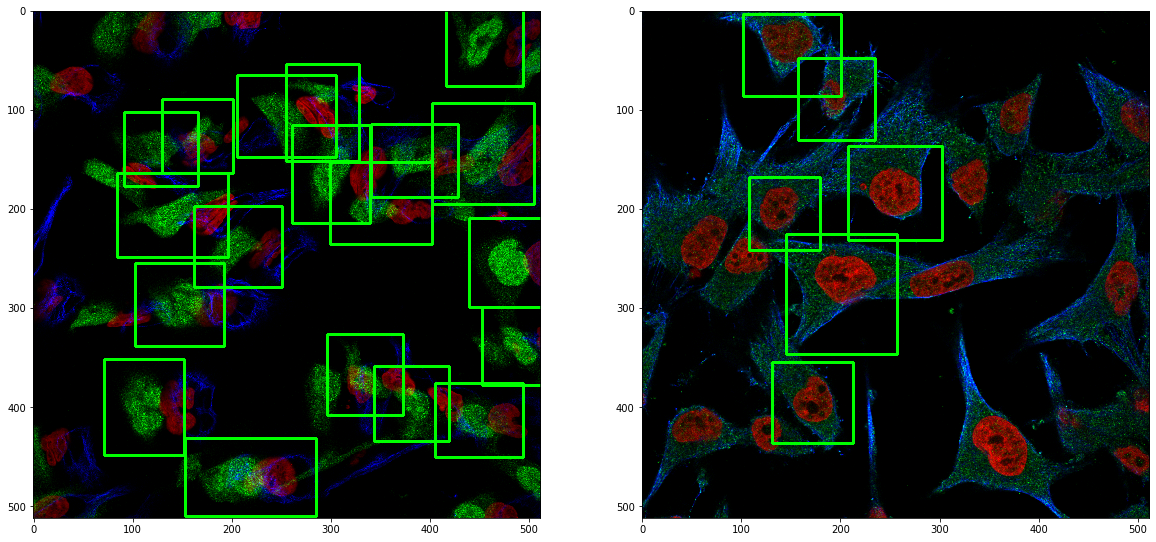

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 15))

img = cv2.imread(temp_path + 'Nucleoplasm_Cytosol_train/' + '00751f10-bbab-11e8-b2ba-ac1f6b6435d0.png')
img2 = cv2.imread(temp_path + 'Nucleoplasm_Cytosol_train/' + '00383b44-bbbb-11e8-b2ba-ac1f6b6435d0.png')

# img_disp = img[:,:,::-1]
# plt.subplot(121)
# plt.imshow(img_disp)
    
imCopy = img.copy()
imgray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 40, 255, 0)
contours, hierarchy =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
#cv2.drawContours(imCopy, contours, -1, (0,255,0))
    
for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = img[y:y + h, x:x + w]
    if w > 30 and w < 100 and h > 30 and h < 100:
        cv2.rectangle(imCopy, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)
plt.subplot(121)
imCopy = imCopy[:,:,::-1]
plt.imshow(imCopy)
        
imCopy2 = img2.copy()
imgray=cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 40, 255, 0)
contours, hierarchy =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
#cv2.drawContours(imCopy, contours, -1, (0,255,0))
    
for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = img[y:y + h, x:x + w]
    if w > 30 and w < 100 and h > 30 and h < 100:
        cv2.rectangle(imCopy2, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)

plt.subplot(122)
imCopy2 = imCopy2[:,:,::-1]
plt.imshow(imCopy2)